**Importing Required Packages**

In [1]:
  import pandas as pd
  import numpy as np
  import matplotlib.pyplot as plt
  import plotly.express as px
  import wordcloud
  import nltk
  import warnings
  warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Text_Analytics/Assignment 1/sms messages.csv')

**Exploratory Data Analysis (EDA)**

In [ ]:
df.head()

,label,message
0,ham,We are okay. Going to sleep now. Later
1,ham,I wont get concentration dear you know you are...
2,ham,Actually i'm waiting for 2 weeks when they sta...
3,ham,Cbe is really good nowadays:)lot of shop and s...
4,ham,"Princess, i like to make love &lt;#&gt; time..."


Let's look at the distribution of labels:

In [ ]:
fig = px.histogram(df, x= "label",color = "label" ,color_discrete_sequence=["#6495ED","#FF8C69"])
fig.show()

We have an imbalanced dataset, with 500 messages being spam messages and 3233 messages being ham.

In [ ]:
fig = px.pie(df.label.value_counts(),labels='index', values='label', color_discrete_sequence=["#6495ED","#FF8C69"] )
fig.show()

The spam makes up 13.4% of the dataset while ham composes 86.6% of the dataset.

Next, we will delve into a little feature engineering. The length of the messages might provide some insights. Let's take a look:

In [ ]:
df['length'] = df['message'].apply(len)
df.head()

,label,message,length
0,ham,We are okay. Going to sleep now. Later,38
1,ham,I wont get concentration dear you know you are...,73
2,ham,Actually i'm waiting for 2 weeks when they sta...,60
3,ham,Cbe is really good nowadays:)lot of shop and s...,77
4,ham,"Princess, i like to make love &lt;#&gt; time...",84


In [ ]:
fig = px.histogram(df, x="length", color="label", color_discrete_sequence=["#6495ED","#FF8C69"] )
fig.show()

It can be seen that ham messages are shorter than spam messages as the distribution of ham and spam message lengths are centered around 30-40 and 155-160 characters, respectively.

Having a view of the most common words used in spams and hams will help us understand the dataset better. A word cloud can give you an idea of what kind of words are dominant in each class.

To make a word cloud, first separate the classes into two data frames and add a simple word cloud function.

In [ ]:
data_ham  = df[df['label'] == "ham"].copy()
data_spam = df[df['label'] == "spam"].copy()

def show_wordcloud(data, title):
    text = ' '.join(data['message'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords, background_color="#FFFAF0",
                                        width = 3000, height = 2000).generate(text)
    plt.figure(figsize=(15,15), frameon=False)
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

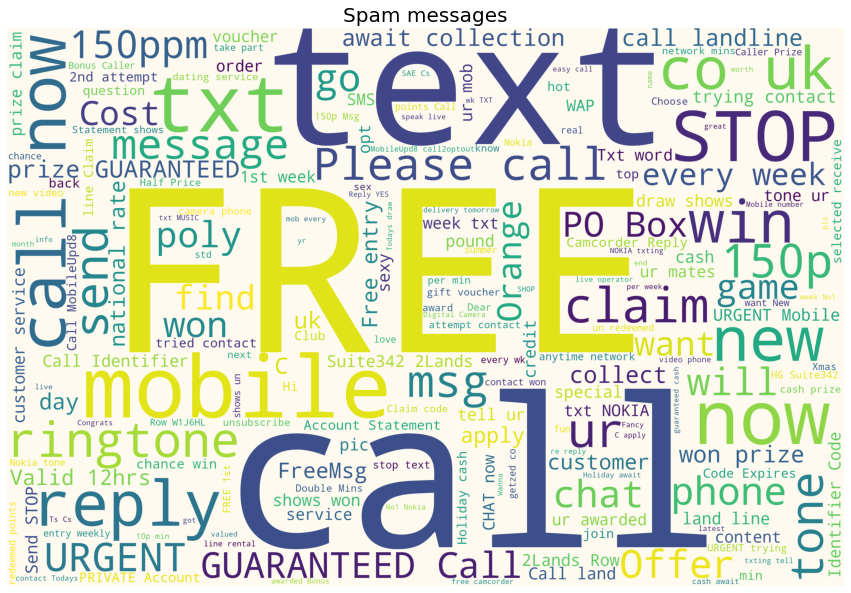

In [ ]:
show_wordcloud(data_spam, "Spam messages")

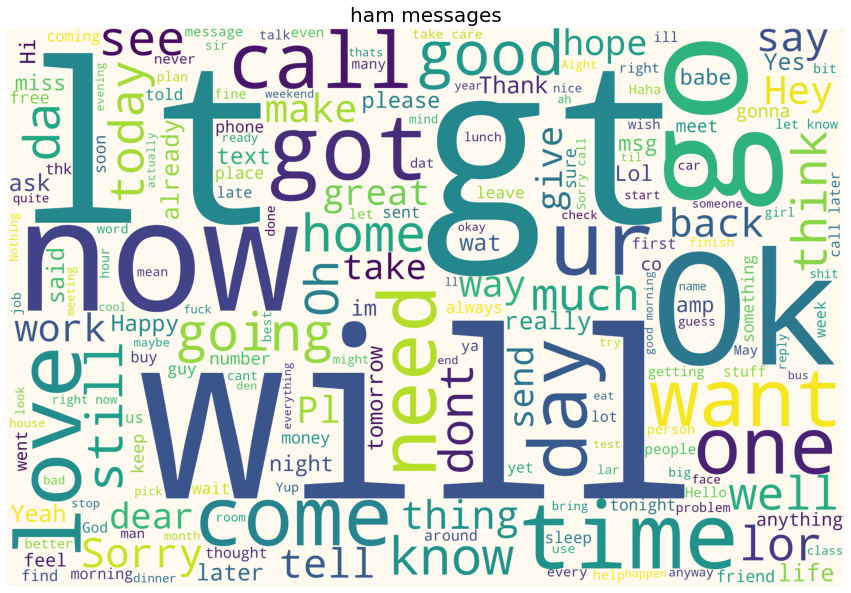

In [ ]:
show_wordcloud(data_ham, "ham messages")

# **Preprocess the Data**

The process of converting data to something a computer can understand is referred to as pre-processing. In the context of this article, this involves processes and techniques to prepare our text data for our machine learning algorithm

First, we’ll convert the label to numeric form. This is essential before model training, as deep learning models need data in numeric form.

Next, we will process the message content with Regular Expressions (Regex) to keep email and web addresses, phone numbers, and numbers uniform, encode symbols, remove punctuation and white spaces, and finally convert all text to lowercase:



In [3]:
df['label'] = df['label'].map( {'spam': 1, 'ham': 0})

In [4]:
# Replace email address with 'emailaddress'
df['message'] = df['message'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$', 'emailaddress')

# Replace urls with 'webaddress'
df['message'] = df['message'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$', 'webaddress')

# Replace money symbol with 'money-symbol'
df['message'] = df['message'].str.replace(r'£|\$', 'money-symbol')

# Replace 10 digit phone number with 'phone-number'
df['message'] = df['message'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$', 'phone-number')

# Replace normal number with 'number'
df['message'] = df['message'].str.replace(r'\d+(\.\d+)?', 'number')

# remove punctuation
df['message'] = df['message'].str.replace(r'[^\w\d\s]', ' ')

# remove whitespace between terms with single space
df['message'] = df['message'].str.replace(r'\s+', ' ')

# remove leading and trailing whitespace
df['message'] = df['message'].str.replace(r'^\s+|\s*?$', ' ')

# change words to lower case
df['message'] = df['message'].str.lower()

# remove non alphabets with whitespace
df['message'] = df['message'].str.replace(r'[^a-zA-Z]', ' ')

Going forward, we'll remove stopwords from the message content. Stop words are words that search engines have been programmed to ignore, both when indexing entries for searching and when retrieving them as the result of a search query such as “the”, “a”, “an”, “in”, "but", "because" etc.

In [5]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
df['message'] = df['message'].apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Next, we will extract the base form of words by removing affixes from them. This called stemming, as it can be illustrated as cutting down the branches of a tree to its stems. There are numerous stemming algorithms, some of these stemming algorithms are aggressive and dynamic. Some apply to languages other than English and the text data size affects various efficiencies. For this article, the Snowball Stemmer was utilized due to its computational speed.



In [6]:
ss = nltk.SnowballStemmer("english")
df['message'] = df['message'].apply(lambda x: ' '.join(ss.stem(term) for term in x.split()))

Machine learning algorithms cannot work with raw text directly. The text must be converted into numbers—more specifically, vectors of numbers. Let's split the messages (text data in sentences) into words. This is a requirement in natural language processing tasks where each word needs to be captured and subjected to further analysis.

In [7]:
import nltk
nltk.download('punkt')
sms_df = df['message']
from nltk.tokenize import word_tokenize

# creating a bag-of-words model
all_words = []
for sms in sms_df:
    words = word_tokenize(sms)
    for w in words:
        all_words.append(w)
     
all_words = nltk.FreqDist(all_words)   

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
print('Number of words: {}'.format(len(all_words)))

Number of words: 5208


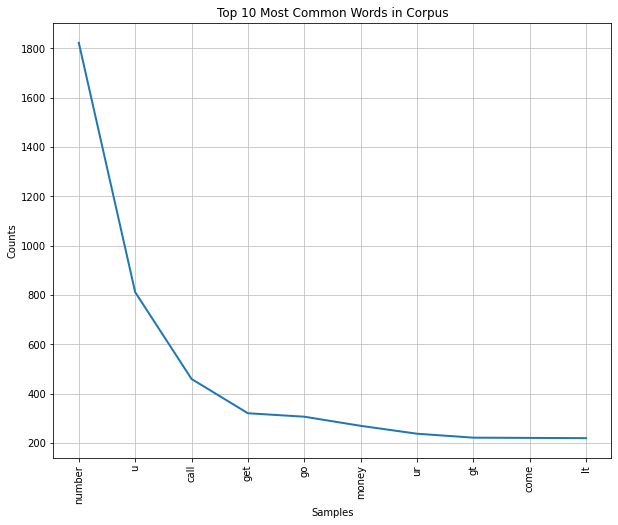

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
all_words.plot(10, title='Top 10 Most Common Words in Corpus');

Next, we will implement an NLP technique—term frequency-inverse document frequency—to evaluate how important words are in the text data. In short, this technique simply defines what a “relevant word” is. The tfidf_model is being used below.

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_model = TfidfVectorizer()
tfidf_vec=tfidf_model.fit_transform(sms_df)
tfidf_data=pd.DataFrame(tfidf_vec.toarray())
tfidf_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,5152,5153,5154,5155,5156,5157,5158,5159,5160,5161,5162,5163,5164,5165,5166,5167,5168,5169,5170,5171,5172,5173,5174,5175,5176,5177,5178,5179,5180,5181,5182,5183,5184,5185,5186,5187,5188,5189,5190,5191
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Test - Train Split**

In order to train and validate the performance of our machine learning model, we need to split the data into training and test dataset respectively. The training set should be later split into a train and validation set.</br>
Since the data we have is imbalanced, we are going to use imblearn's Synthetic Minority Oversampling Technique to upsample my minority data class in the data.

In [9]:
### Separating Columns
df_train = tfidf_data.iloc[:4457]
df_test = tfidf_data.iloc[4457:]

target = df['label']
df_train['label'] = target

Y = df_train['label']
X = df_train.drop('label',axis=1)

# splitting training data into train and validation using sklearn
from sklearn import model_selection
X_train,X_test,y_train,y_test = model_selection.train_test_split(X,Y,test_size=.2, random_state=42)

In [10]:
from imblearn.over_sampling import BorderlineSMOTE
sm = BorderlineSMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

**Model Building**

We will be utilizing a machine learning algorithm known as LightGBM. It is a gradient boosting framework that uses tree based learning algorithms. It has the following benefits:

Faster training speed and higher efficiency

1. Lower memory usage
2. Better accuracy
3. Support of parallel and GPU learning
4. Capable of handling large-scale data




In [ ]:
import lightgbm as lgb
from sklearn.metrics import precision_score, accuracy_score,recall_score
def train_and_test(model, model_name):
    model.fit(X_train_resampled, y_train_resampled)
    pred = model.predict(X_test)
    print(f'Precision score is: {precision_score(pred, y_test)}')
    
for depth in [1,2,3,4,5,6,7,8,9,10]:
    lgbmodel = lgb.LGBMClassifier(max_depth=depth, n_estimators=200, num_leaves=40)
    print(f"Max Depth {depth}")
    print(" ")
    print(" ")
    train_and_test(lgbmodel, "Light GBM")

Max Depth 1
 
 
Precision score is: 0.898989898989899
Max Depth 2
 
 
Precision score is: 0.9191919191919192
Max Depth 3
 
 
Precision score is: 0.9292929292929293
Max Depth 4
 
 
Precision score is: 0.9191919191919192
Max Depth 5
 
 
Precision score is: 0.9191919191919192
Max Depth 6
 
 
Precision score is: 0.9292929292929293
Max Depth 7
 
 
Precision score is: 0.9292929292929293
Max Depth 8
 
 
Precision score is: 0.9292929292929293
Max Depth 9
 
 
Precision score is: 0.9191919191919192
Max Depth 10
 
 
Precision score is: 0.9292929292929293


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
lgbmodel_bst = lgb.LGBMClassifier(max_depth=6, n_estimators=200, num_leaves=40)
param_grid = {
    'num_leaves': list(range(8, 92, 4)),
    'min_data_in_leaf': [10, 20, 40, 60, 100],
    'max_depth': [3, 4, 5, 6, 8, 12, 16, -1],
    'learning_rate': [0.1, 0.05, 0.01, 0.005],
    'bagging_freq': [3, 4, 5, 6, 7],
    'bagging_fraction': np.linspace(0.6, 0.95, 10),
    'reg_alpha': np.linspace(0.1, 0.95, 10),
    'reg_lambda': np.linspace(0.1, 0.95, 10),
    "min_split_gain": [0.0, 0.1, 0.01],
    "min_child_weight": [0.001, 0.01, 0.1, 0.001],
    "min_child_samples": [20, 30, 25],
    "subsample": [1.0, 0.5, 0.8],
}
model = RandomizedSearchCV(lgbmodel_bst, param_grid, random_state=1)
search = model.fit(X_train_resampled, y_train_resampled)
search.best_params_

{'bagging_fraction': 0.6,
 'bagging_freq': 3,
 'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_samples': 30,
 'min_child_weight': 0.01,
 'min_data_in_leaf': 10,
 'min_split_gain': 0.01,
 'num_leaves': 88,
 'reg_alpha': 0.5722222222222222,
 'reg_lambda': 0.47777777777777775,
 'subsample': 0.5}

In [ ]:
best_model = lgb.LGBMClassifier(subsample=0.5,
                            reg_lambda= 0.47777777777777775,
                            reg_alpha= 0.5722222222222222,
                            num_leaves= 88,
                            min_split_gain= 0.01,
                            min_data_in_leaf= 10,
                            min_child_weight= 0.01,
                            min_child_samples= 30,
                            max_depth= 3,
                            learning_rate= 0.1,
                            bagging_freq= 3,
                            bagging_fraction= 0.6,
                            random_state=1)
best_model.fit(X_train_resampled,y_train_resampled)

LGBMClassifier(bagging_fraction=0.6, bagging_freq=3, max_depth=3,
               min_child_samples=30, min_child_weight=0.01, min_data_in_leaf=10,
               min_split_gain=0.01, num_leaves=88, random_state=1,
               reg_alpha=0.5722222222222222, reg_lambda=0.47777777777777775,
               subsample=0.5)

In [ ]:
prediction = best_model.predict(X_test)
print(f'Precision score is: {precision_score(prediction, y_test)}')

Precision score is: 0.9191919191919192


In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print (classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       648
           1       0.94      0.92      0.93        99

    accuracy                           0.98       747
   macro avg       0.96      0.95      0.96       747
weighted avg       0.98      0.98      0.98       747



Building a function which can be used to run multiple models for the given data and then compare the model performce evaluation metrics together for selecting the best model out of these.

Since the data we have is an imbalanced data set, choosing accuracy alone is not a wise way for evaluating model performance.

**Accuracy** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

**Precision** tells us what proportion of messages we classified as spam, actually were spam. It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classification)


**Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam. It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam.

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn import metrics

In [12]:
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)
xgb = XGBClassifier(n_estimators=50,random_state=2)

In [13]:
clfs = {
    'KN' : knc, 
    'NB': mnb, 
    'DT': dtc, 
    'LR': lrc, 
    'RF': rfc, 
    'AdaBoost': abc, 
    'BgC': bc, 
    'ETC': etc,
    'GBDT':gbdt,
    'xgb':xgb
}

In [15]:
def train_classifier(clf,X_train_resampled,y_train_resampled,X_test,y_test):
    clf.fit(X_train_resampled,y_train_resampled)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    predslog = clf.predict_proba(X_test)[:,1]
    auc = metrics.roc_auc_score(y_test,predslog, average='macro', sample_weight=None)
    return accuracy,precision,recall,auc

In [16]:
from sklearn import metrics
from sklearn.metrics import precision_score, accuracy_score,recall_score

accuracy_scores = []
precision_scores = []
recall_scores = []
auc_scores = []

for name,clf in clfs.items():
    
    current_accuracy,current_precision,current_recall,current_auc = train_classifier(clf, X_train_resampled,y_train_resampled,X_test,y_test)
    
    print("For ",name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision)
    print("Recall - ",current_recall)
    print("AUC - ",current_auc)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)
    recall_scores.append(current_recall)
    auc_scores.append(current_auc)

For  KN
Accuracy -  0.9544846050870147
Precision -  0.9850746268656716
Recall -  0.6666666666666666
AUC -  0.8478925052999128
For  NB
Accuracy -  0.9692101740294511
Precision -  0.8275862068965517
Recall -  0.9696969696969697
AUC -  0.9934374610300537
For  DT
Accuracy -  0.8942436412315931
Precision -  0.5609756097560976
Recall -  0.9292929292929293
AUC -  0.9468761690983913
For  LR
Accuracy -  0.9745649263721553
Precision -  0.8846153846153846
Recall -  0.9292929292929293
AUC -  0.9846614291058736
For  RF
Accuracy -  0.9825970548862115
Precision -  0.9777777777777777
Recall -  0.8888888888888888
AUC -  0.9965862326973438
For  AdaBoost
Accuracy -  0.9812583668005355
Precision -  0.9381443298969072
Recall -  0.9191919191919192
AUC -  0.9841158498565906
For  BgC
Accuracy -  0.9812583668005355
Precision -  0.9381443298969072
Recall -  0.9191919191919192
AUC -  0.9859006734006734
For  ETC
Accuracy -  0.9785809906291834
Precision -  0.9560439560439561
Recall -  0.8787878787878788
AUC -  0.9

In [17]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores,'Recall':recall_scores,'AUC':auc_scores
                               }).sort_values('Precision',ascending=False)
performance_df

,Algorithm,Accuracy,Precision,Recall,AUC
0,KN,0.954485,0.985075,0.666667,0.847893
4,RF,0.982597,0.977778,0.888889,0.996586
7,ETC,0.978581,0.956044,0.878788,0.995511
8,GBDT,0.981258,0.947368,0.909091,0.975309
5,AdaBoost,0.981258,0.938144,0.919192,0.984116
6,BgC,0.981258,0.938144,0.919192,0.985901
9,xgb,0.977242,0.936170,0.888889,0.975480
3,LR,0.974565,0.884615,0.929293,0.984661
1,NB,0.969210,0.827586,0.969697,0.993437
2,DT,0.894244,0.560976,0.929293,0.946876


In [18]:
performance_df1 = pd.melt(performance_df, id_vars = "Algorithm")

In [19]:
import plotly.express as px
df = performance_df1
fig = px.bar(df, x="Algorithm", y="value",
             color='variable', barmode='group', color_discrete_sequence=["#6495ED","#FF8C69","#7CCD7C","#E3A869"],
             height = 500, width = 1000,title="Model Performances Comparison")
fig.show()

Since the performance of the models are not as expected, we shall now try and replicate the same with non sampled data and then evaluate the models as above.

In [20]:
from sklearn import metrics
from sklearn.metrics import precision_score, accuracy_score,recall_score

accuracy_scores = []
precision_scores = []
recall_scores = []
auc_scores = []

for name,clf in clfs.items():
    
    current_accuracy,current_precision,current_recall,current_auc = train_classifier(clf, X_train,y_train,X_test,y_test)
    
    print("For ",name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision)
    print("Recall - ",current_recall)
    print("AUC - ",current_auc)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)
    recall_scores.append(current_recall)
    auc_scores.append(current_auc)

For  KN
Accuracy -  0.9089692101740294
Precision -  1.0
Recall -  0.31313131313131315
AUC -  0.8124454420750717
For  NB
Accuracy -  0.9692101740294511
Precision -  1.0
Recall -  0.7676767676767676
AUC -  0.9852693602693603
For  DT
Accuracy -  0.963855421686747
Precision -  0.95
Recall -  0.7676767676767676
AUC -  0.9387392442947999
For  LR
Accuracy -  0.965194109772423
Precision -  0.9195402298850575
Recall -  0.8080808080808081
AUC -  0.9774441950367875
For  RF
Accuracy -  0.9839357429718876
Precision -  1.0
Recall -  0.8787878787878788
AUC -  0.9948793490460157
For  AdaBoost
Accuracy -  0.9745649263721553
Precision -  0.9347826086956522
Recall -  0.8686868686868687
AUC -  0.9564783638857712
For  BgC
Accuracy -  0.9825970548862115
Precision -  0.967391304347826
Recall -  0.898989898989899
AUC -  0.9761971567527123
For  ETC
Accuracy -  0.9772423025435074
Precision -  0.9456521739130435
Recall -  0.8787878787878788
AUC -  0.9957834518019705
For  GBDT
Accuracy -  0.9825970548862115
Preci

In [21]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores,'Recall':recall_scores,'AUC':auc_scores
                               }).sort_values('Precision',ascending=False)
performance_df

,Algorithm,Accuracy,Precision,Recall,AUC
0,KN,0.908969,1.000000,0.313131,0.812445
1,NB,0.969210,1.000000,0.767677,0.985269
4,RF,0.983936,1.000000,0.878788,0.994879
8,GBDT,0.982597,0.977778,0.888889,0.969713
6,BgC,0.982597,0.967391,0.898990,0.976197
9,xgb,0.978581,0.966292,0.868687,0.966556
2,DT,0.963855,0.950000,0.767677,0.938739
7,ETC,0.977242,0.945652,0.878788,0.995783
5,AdaBoost,0.974565,0.934783,0.868687,0.956478
3,LR,0.965194,0.919540,0.808081,0.977444


In [22]:
performance_df2 = pd.melt(performance_df, id_vars = "Algorithm")

In [23]:
import plotly.express as px
df = performance_df2
fig = px.bar(df, x="Algorithm", y="value",
             color='variable', barmode='group', color_discrete_sequence=["#6495ED","#FF8C69","#7CCD7C","#E3A869"],
             height = 500, width = 1000,title="Model Performances Comparison")
fig.show()

# **Final Suggestions:**

From the above graphs and metrics, we can see that ***Random Forest classifier*** gives the best results as it has very high precision in case of non sampled data and also recall is comparatively high amongst all the models in both the cases.